In [54]:
%matplotlib inline
%reload_ext autoreload

In [55]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from tqdm.auto import tqdm
from tensorboardX import SummaryWriter

import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [56]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [57]:
from src.data.gp_curves import GPCurvesReader
from src.models.model import LatentModel

## Util

In [58]:
def set_seed(n=42):
    np.random.seed(n)
    torch.manual_seed(n)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

In [59]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
          target_x[0, :, 0],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()

In [60]:
def test(model, dataset_test, writer=None, plot=False, global_step=None, seed=42):
    model.eval()
    with torch.no_grad():
        data_test = dataset_test.generate_curves()

        (context_x, context_y), target_x = data_test.query
        target_y = data_test.target_y

        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        target_y = target_y.cuda()

        y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x, target_y)

        # Lets order the result, for plotting
        target_inds = torch.argsort(target_x[0, :, 0])
        target_x = target_x[:, target_inds, :]
        target_y = target_y[:, target_inds, :]
        context_inds = torch.argsort(context_x[0, :, 0])
        context_y = context_y[:, context_inds, :]
        context_x = context_x[:, context_inds, :]
        y_pred = y_pred[:, target_inds, :]
        y_std = y_std[:, target_inds, :]
        
        if writer is not None:
            writer.add_scalar('val/loss', loss, global_step=global_step)
            writer.add_scalar('val/y_std', y_std.mean(), global_step=global_step)
            writer.add_scalar('val/mse_loss', mse_loss, global_step=global_step)
            writer.add_scalar('val/kl', kl.mean(), global_step=global_step)
        
        if plot:
            set_seed(seed)
            fig = plt.figure()
            plt.title(f"Iter {global_step}")            
            plot_functions(target_x.detach().cpu().numpy(),
                           target_y.detach().cpu().numpy(),
                           context_x.detach().cpu().numpy(),
                           context_y.detach().cpu().numpy(),
                           y_pred.detach().cpu().numpy(),
                           y_std.detach().cpu().numpy())
            
            writer.add_figure('test', fig, global_step=global_step, close=False)
            plt.show()
            
    return y_pred, kl, loss, y_std

# Init

In [61]:

MAX_CONTEXT_POINTS = 50 
random_kernel_parameters=True 

dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)

dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)



## Replicate ANP paper

In [62]:
epochs = 100000
PLOT_AFTER = 10000
PRINT_AFTER = 1000

runs/Feb01_21-01-09_mjcdesktop-anp_1d_reg


train: 0 loss= 0.9901 val_loss= 1.203


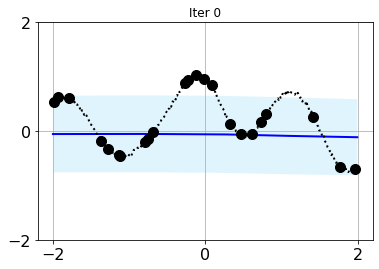

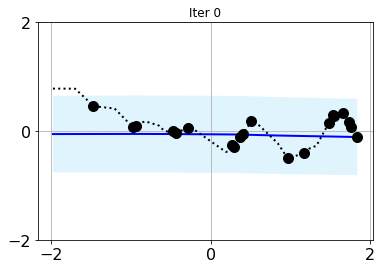

train: 1000 loss= 0.2283 val_loss=-0.5778
train: 2000 loss= 0.141 val_loss= 0.2598
train: 3000 loss=-0.02194 val_loss= 1.127
train: 4000 loss= 0.1633 val_loss= 0.2397
train: 5000 loss=-0.2981 val_loss= 1.3
train: 6000 loss=-0.2146 val_loss=-0.7948
train: 7000 loss= 0.4765 val_loss=-0.4249
train: 8000 loss=-0.4619 val_loss= 0.3319
train: 9000 loss= 0.2651 val_loss= 0.0496
train: 10000 loss=-0.3873 val_loss= 0.4204


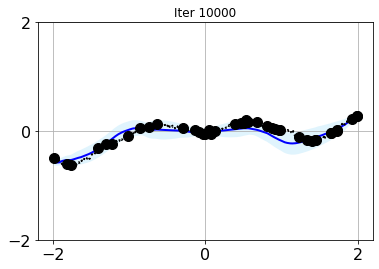

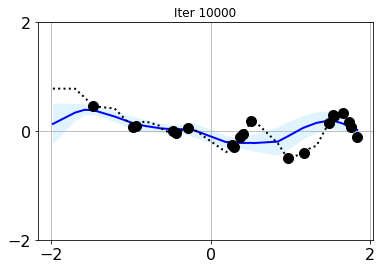

train: 11000 loss=-0.6022 val_loss=-0.1339
train: 12000 loss=-0.7479 val_loss= 0.1351
train: 13000 loss=-0.8724 val_loss=-0.7456
train: 14000 loss=-0.319 val_loss=-0.617
train: 15000 loss=-0.6649 val_loss=-1.035
train: 16000 loss=-0.4514 val_loss=-0.1827
train: 17000 loss=-0.5549 val_loss= 0.06608
train: 18000 loss=-0.7057 val_loss=-1.228
train: 19000 loss=-0.4386 val_loss=-0.3513
train: 20000 loss=-0.6165 val_loss=-0.6527



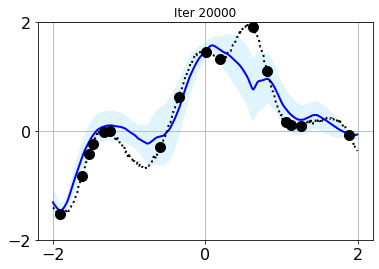

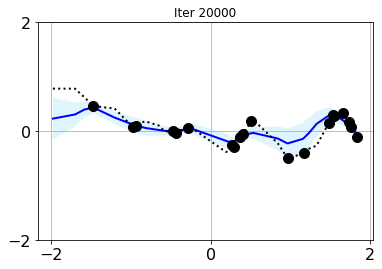

train: 21000 loss=-0.2358 val_loss=-0.1649
train: 22000 loss=-0.7763 val_loss=-0.8249
train: 23000 loss=-0.3989 val_loss= 0.07137
train: 24000 loss= 0.183 val_loss=-0.3059
train: 25000 loss=-1.005 val_loss= 0.5692
train: 26000 loss=-0.6361 val_loss=-1.653
train: 27000 loss=-0.7043 val_loss= 0.9915
train: 28000 loss=-1.054 val_loss=-1.052
train: 29000 loss=-0.5186 val_loss=-0.3443
train: 30000 loss=-0.4902 val_loss=-0.03693


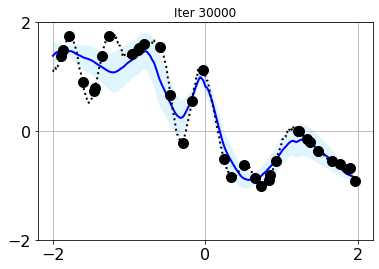

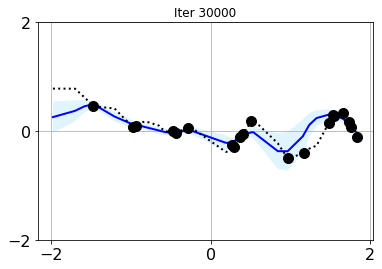

train: 31000 loss=-1.075 val_loss=-0.7518
train: 32000 loss=-0.7325 val_loss=-1.555
train: 33000 loss=-0.8459 val_loss=-0.272
train: 34000 loss=-0.6167 val_loss=-0.4969
train: 35000 loss=-0.5839 val_loss=-1.162
train: 36000 loss=-0.9839 val_loss=-1.722
train: 37000 loss=-0.7776 val_loss= 0.1143
train: 38000 loss=-0.7039 val_loss=-0.9417
train: 39000 loss=-0.6321 val_loss=-1.303
train: 40000 loss=-0.8522 val_loss=-0.1387


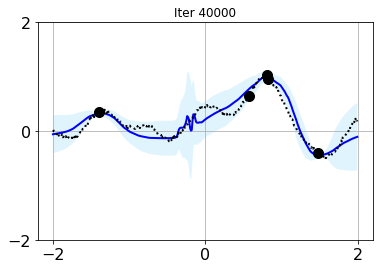

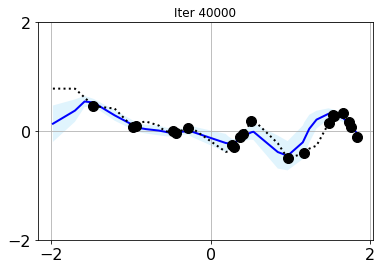

train: 41000 loss=-1.062 val_loss=-0.05956
train: 42000 loss=-1.14 val_loss=-0.5668
train: 43000 loss=-0.7403 val_loss= 0.5438
train: 44000 loss=-0.9275 val_loss=-0.1802
train: 45000 loss=-0.8797 val_loss=-0.154
train: 46000 loss=-1.049 val_loss=-0.1875
train: 47000 loss=-1.019 val_loss=-1.753
train: 48000 loss=-1.31 val_loss=-0.4702
train: 49000 loss=-0.7908 val_loss=-0.814
train: 50000 loss=-1.019 val_loss=-0.3179


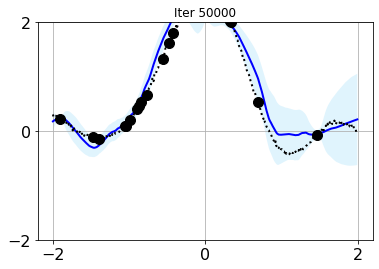

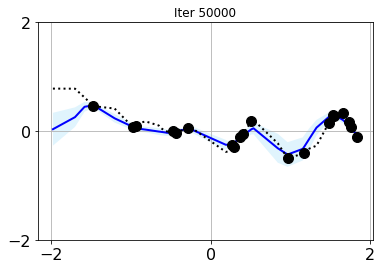

train: 51000 loss=-0.796 val_loss=-0.3768
train: 52000 loss=-1.034 val_loss=-0.8259
train: 53000 loss=-0.5959 val_loss= 0.806
train: 54000 loss=-0.7591 val_loss= 0.3678
train: 55000 loss=-0.9368 val_loss=-0.1205
train: 56000 loss=-1.392 val_loss=-1.612
train: 57000 loss=-1.235 val_loss=-1.785
train: 58000 loss=-1.055 val_loss= 0.6461
train: 59000 loss=-1.266 val_loss= 0.6836
train: 60000 loss=-0.2273 val_loss=-0.9401


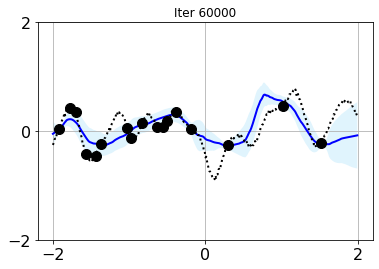

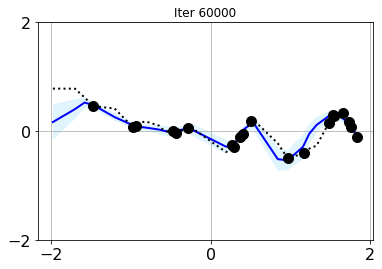

train: 61000 loss=-0.6909 val_loss=-0.2672
train: 62000 loss=-1.219 val_loss=-1.08
train: 63000 loss=-0.6516 val_loss=-0.1455
train: 64000 loss=-1.158 val_loss=-1.255
train: 65000 loss=-1.053 val_loss= 0.9945
train: 66000 loss=-1.304 val_loss=-1.819
train: 67000 loss=-0.7711 val_loss= 0.2355
train: 68000 loss=-1.272 val_loss=-1.704
train: 69000 loss=-1.325 val_loss=-0.1996
train: 70000 loss=-0.832 val_loss= 1.172


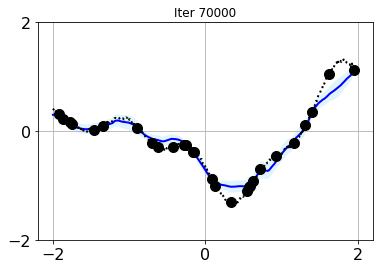

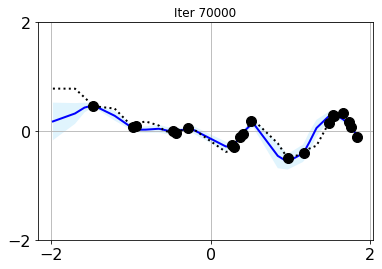

train: 71000 loss=-1.294 val_loss=-0.5367
train: 72000 loss=-0.9753 val_loss=-2.084
train: 73000 loss=-1.193 val_loss=-0.9146
train: 74000 loss=-1.119 val_loss=-0.4217
train: 75000 loss=-1.286 val_loss=-0.9784
train: 76000 loss=-0.7448 val_loss=-0.8317
train: 77000 loss=-1.421 val_loss=-1.213
train: 78000 loss=-0.6679 val_loss=-1.24
train: 79000 loss=-1.619 val_loss=-1.49
train: 80000 loss=-1.173 val_loss=-0.7005


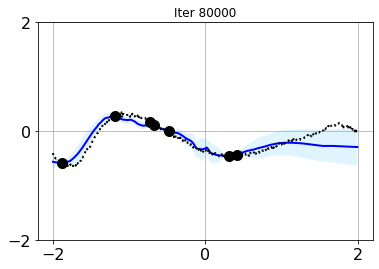

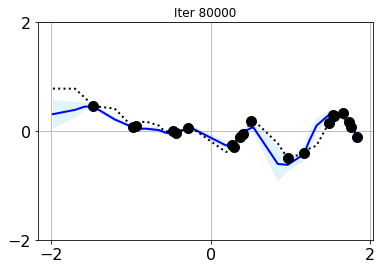

train: 81000 loss=-1.338 val_loss= 0.01664
train: 82000 loss=-1.147 val_loss=-2.089
train: 83000 loss=-0.6598 val_loss=-0.5354
train: 84000 loss=-1.014 val_loss=-1.317
train: 85000 loss=-1.322 val_loss=-0.8638
train: 86000 loss=-0.9507 val_loss=-0.6958
train: 87000 loss=-1.516 val_loss=-0.1163
train: 88000 loss=-1.21 val_loss=-2.103
train: 89000 loss=-0.8139 val_loss=-1.801
train: 90000 loss=-1.155 val_loss=-1.002


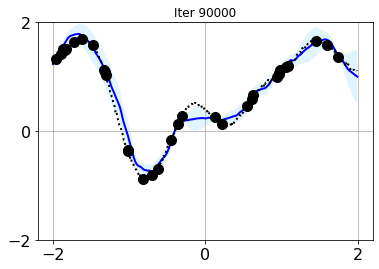

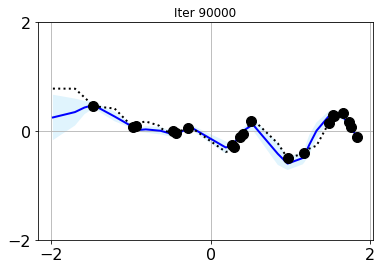

train: 91000 loss=-0.9485 val_loss=-1.883
train: 92000 loss=-0.7806 val_loss=-0.5944
train: 93000 loss=-1.427 val_loss=-1.137
train: 94000 loss=-1.471 val_loss= 0.6587
train: 95000 loss=-1.312 val_loss=-1.141
train: 96000 loss=-1.19 val_loss=-0.7824
train: 97000 loss=-0.6071 val_loss=-0.6734
train: 98000 loss=-1.387 val_loss=-0.2842
train: 99000 loss=-1.024 val_loss= 0.01523



In [63]:


writer = SummaryWriter(comment='-anp_1d_reg')
print(writer.logdir)

hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="multihead",
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead")
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter % PLOT_AFTER == 0:
        test(model, dataset_test, writer, plot=True, global_step=n_iter)
        
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter)

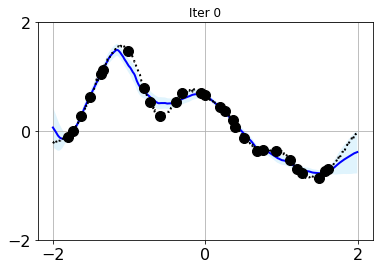

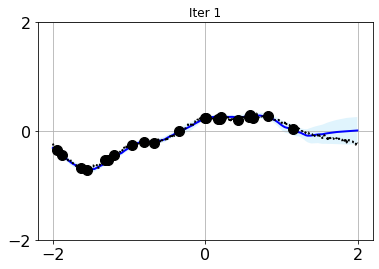

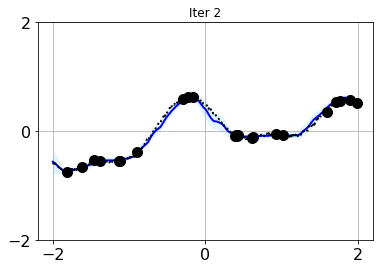

In [64]:
for i in range(3):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=i, seed=i)

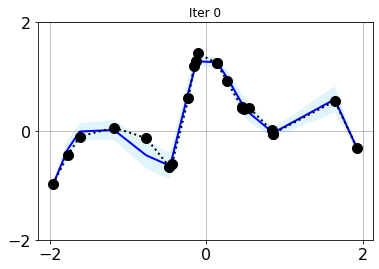

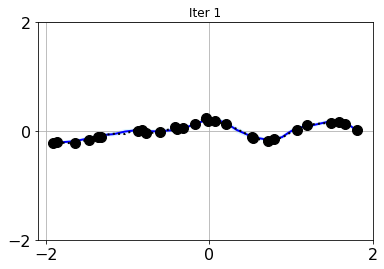

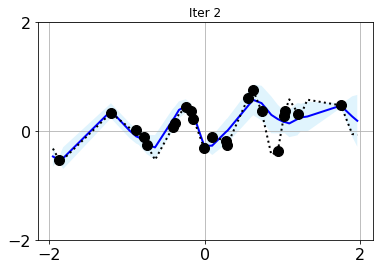

In [65]:
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=i, seed=i)

In [66]:
# Final validation
loss = torch.stack([test(model, dataset_test)[2] for _ in tqdm(range(100))]).mean().cpu()
print('val loss (n=100)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))


val loss (n=100) tensor(-0.8646)


## Improved

These have no been extensively tested:

- use torches ~50% faster multiheaded attention
- calc loss in log domain for stability (and untested changes to clipping)
- dropout

runs/Feb01_23-26-58_mjcdesktop-anp_1d_impr


train: 0 loss= 1.66 val_loss= 1.457


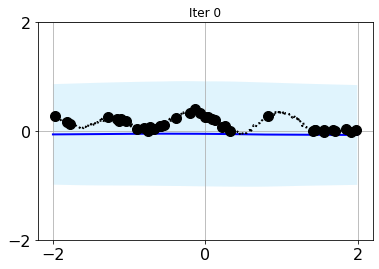

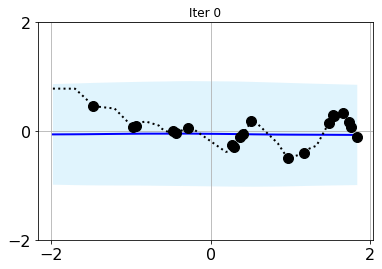

train: 1000 loss= 0.2346 val_loss=-0.6747
train: 2000 loss= 0.1635 val_loss= 0.315
train: 3000 loss= 0.06675 val_loss= 1.185
train: 4000 loss= 0.155 val_loss=-0.04905
train: 5000 loss=-0.1739 val_loss= 1.384
train: 6000 loss= 0.06595 val_loss=-0.3293
train: 7000 loss= 0.9722 val_loss=-0.1167
train: 8000 loss=-0.1602 val_loss= 0.5385
train: 9000 loss= 0.5204 val_loss= 0.2312
train: 10000 loss=-0.1201 val_loss= 0.5715


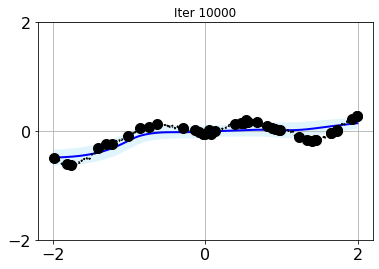

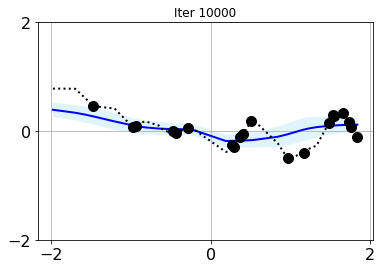

train: 11000 loss=-0.246 val_loss= 0.2482
train: 12000 loss=-0.3654 val_loss= 0.8571
train: 13000 loss=-0.3429 val_loss=-0.3089
train: 14000 loss= 0.1667 val_loss=-0.5312
train: 15000 loss=-0.05928 val_loss= 0.236
train: 16000 loss=-0.03568 val_loss= 0.002041
train: 17000 loss=-0.06225 val_loss= 0.1638
train: 18000 loss=-0.2034 val_loss=-0.5371
train: 19000 loss=-0.06715 val_loss= 0.2504
train: 20000 loss=-0.1886 val_loss=-0.2158


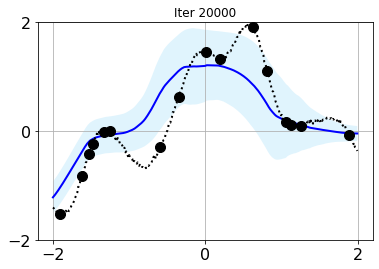

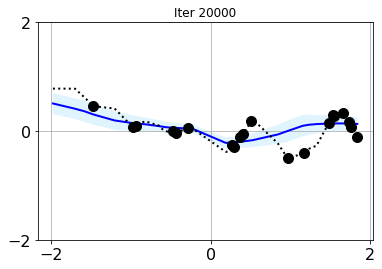

train: 21000 loss=-0.1663 val_loss=-0.3638
train: 22000 loss=-0.3555 val_loss=-0.02034
train: 23000 loss=-0.003735 val_loss= 0.4405
train: 24000 loss=-0.01453 val_loss= 0.02991
train: 25000 loss=-0.5452 val_loss= 0.5273
train: 26000 loss=-0.4023 val_loss=-1.654
train: 27000 loss=-0.3546 val_loss= 1.217
train: 28000 loss=-0.8688 val_loss=-1.209
train: 29000 loss=-0.3726 val_loss=-0.247
train: 30000 loss=-0.3504 val_loss=-0.1419


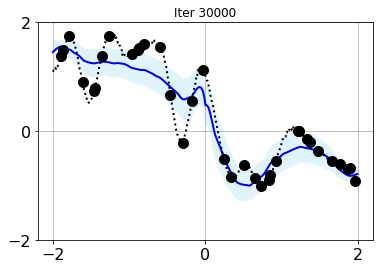

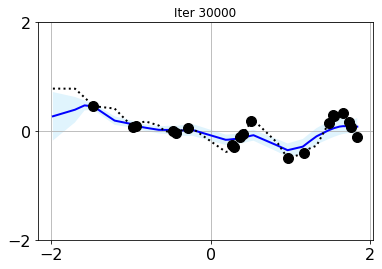

train: 31000 loss=-1.07 val_loss=-1.122
train: 32000 loss=-0.7569 val_loss=-1.905
train: 33000 loss=-0.8855 val_loss=-0.1284
train: 34000 loss=-0.744 val_loss=-0.7068
train: 35000 loss=-0.6671 val_loss=-1.456
train: 36000 loss=-1.196 val_loss=-2.031
train: 37000 loss=-1.076 val_loss=-0.02586
train: 38000 loss=-0.9341 val_loss=-1.009
train: 39000 loss=-0.6252 val_loss=-1.563
train: 40000 loss=-0.9949 val_loss=-0.7833


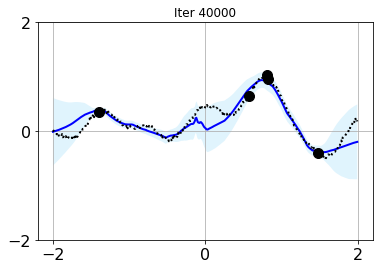

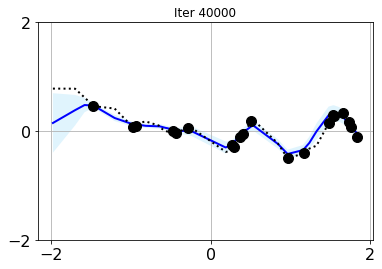

train: 41000 loss=-1.376 val_loss=-0.1559
train: 42000 loss=-1.452 val_loss=-1.198
train: 43000 loss=-0.8674 val_loss= 0.3678
train: 44000 loss=-1.239 val_loss=-0.7432
train: 45000 loss=-0.9778 val_loss=-1.205
train: 46000 loss=-1.355 val_loss=-1.026
train: 47000 loss=-1.237 val_loss=-1.892
train: 48000 loss=-1.548 val_loss=-1.017
train: 49000 loss=-1.155 val_loss=-1.373
train: 50000 loss=-1.267 val_loss=-0.9196


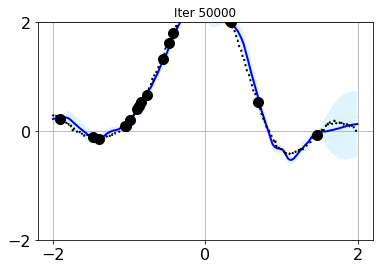

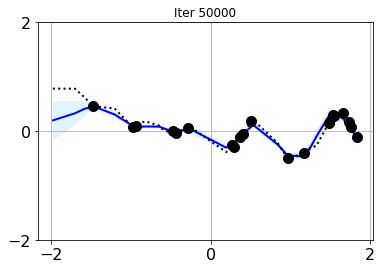

train: 51000 loss=-1.049 val_loss=-0.8146
train: 52000 loss=-1.309 val_loss=-1.071
train: 53000 loss=-0.9399 val_loss= 0.8218
train: 54000 loss=-1.08 val_loss=-0.05891
train: 55000 loss=-1.319 val_loss=-0.7948
train: 56000 loss=-1.765 val_loss=-1.974
train: 57000 loss=-1.632 val_loss=-2.255
train: 58000 loss=-1.441 val_loss= 0.002214
train: 59000 loss=-1.627 val_loss= 0.1506
train: 60000 loss=-0.7349 val_loss=-1.395


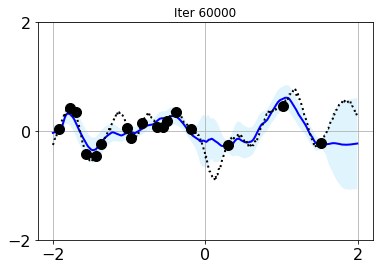

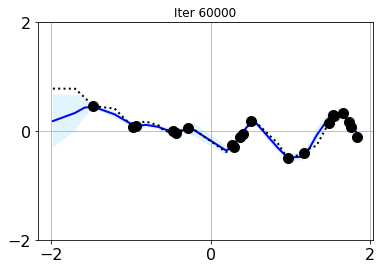

train: 61000 loss=-1.107 val_loss=-1.13
train: 62000 loss=-1.726 val_loss=-1.811
train: 63000 loss=-1.163 val_loss=-0.176
train: 64000 loss=-1.494 val_loss=-1.848
train: 65000 loss=-1.399 val_loss= 0.7774
train: 66000 loss=-1.596 val_loss=-1.886
train: 67000 loss=-0.9347 val_loss=-0.5104
train: 68000 loss=-1.317 val_loss=-1.838
train: 69000 loss=-1.682 val_loss=-0.4937
train: 70000 loss=-0.9635 val_loss= 0.3594


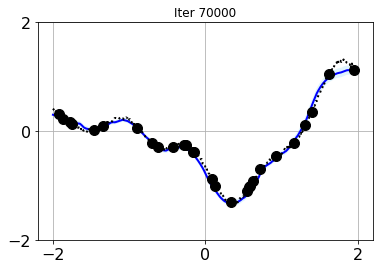

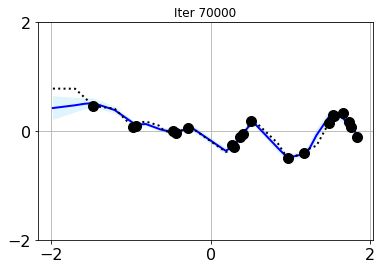

train: 71000 loss=-1.66 val_loss=-1.048
train: 72000 loss=-1.506 val_loss=-2.102
train: 73000 loss=-1.588 val_loss=-1.467
train: 74000 loss=-1.632 val_loss=-0.766
train: 75000 loss=-1.667 val_loss=-1.177
train: 76000 loss=-1.106 val_loss=-1.301
train: 77000 loss=-1.89 val_loss=-1.436
train: 78000 loss=-1.159 val_loss=-2.02
train: 79000 loss=-2.078 val_loss=-1.704
train: 80000 loss=-1.68 val_loss=-1.441


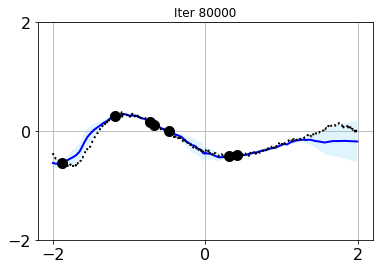

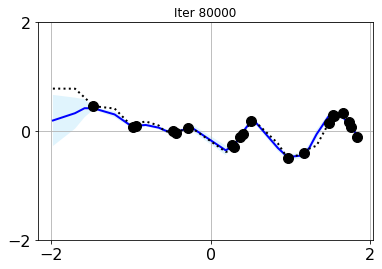

train: 81000 loss=-1.63 val_loss=-0.6517
train: 82000 loss=-1.532 val_loss=-2.119
train: 83000 loss=-1.252 val_loss=-1.494
train: 84000 loss=-1.372 val_loss=-1.631
train: 85000 loss=-1.611 val_loss=-1.697
train: 86000 loss=-1.321 val_loss=-1.236
train: 87000 loss=-1.923 val_loss=-0.7022
train: 88000 loss=-1.625 val_loss=-2.153
train: 89000 loss=-1.087 val_loss=-2.136
train: 90000 loss=-1.476 val_loss=-1.422


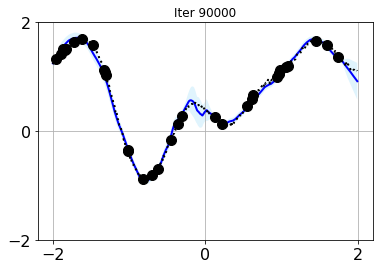

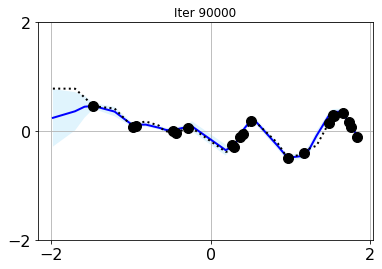

train: 91000 loss=-1.484 val_loss=-2.06
train: 92000 loss=-1.242 val_loss=-1.477
train: 93000 loss=-1.907 val_loss=-1.68
train: 94000 loss=-1.732 val_loss= 0.3016
train: 95000 loss=-1.754 val_loss=-1.611
train: 96000 loss=-1.7 val_loss=-1.685
train: 97000 loss=-1.062 val_loss=-1.34
train: 98000 loss=-1.787 val_loss=-0.3952
train: 99000 loss=-1.542 val_loss=-0.3366



In [67]:
writer = SummaryWriter(comment='-anp_1d_impr')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="ptmultihead",
    det_enc_self_attn_type="ptmultihead",
    det_enc_cross_attn_type="ptmultihead",
    min_std=1e-3,
    use_lvar=True,
    use_self_attn=True,
#     attention_dropout=0.3,
#     dropout=0.3,
#     batchnorm=True,
)
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter % PLOT_AFTER == 0:
        test(model, dataset_test, writer, plot=True, global_step=n_iter)
        test(model, dataset_train, writer, plot=True, global_step=n_iter, seed=n_iter)

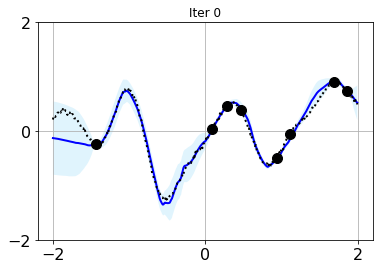

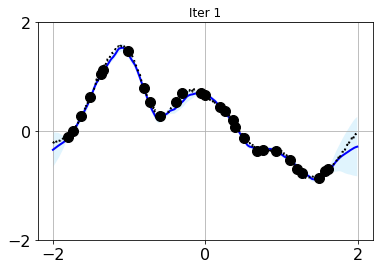

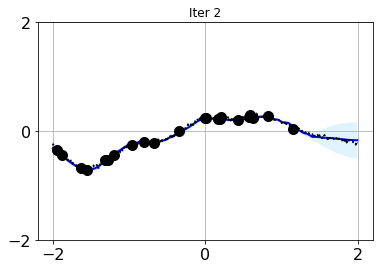

In [68]:
for i in range(3):
    test(model, dataset_test, writer, plot=True, global_step=i, seed=i)

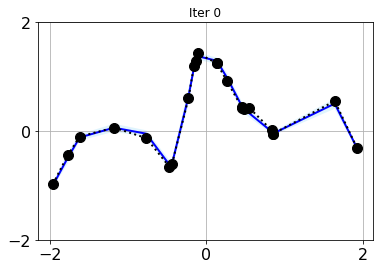

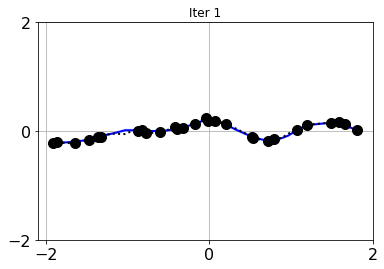

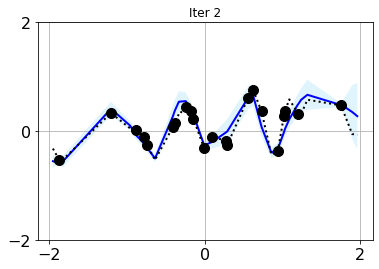

In [69]:
for i in range(3):
    test(model, dataset_train, writer, plot=True, global_step=i, seed=i)

In [70]:
# Final validation
loss = torch.stack([test(model, dataset_test)[2] for _ in tqdm(range(100))]).mean().cpu()
print('val loss (n=100)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))


val loss (n=100) tensor(-1.3316)


In [71]:
(hparams, dict(val_loss=loss))

({'x_dim': 1,
  'y_dim': 1,
  'hidden_dim': 128,
  'latent_dim': 128,
  'latent_enc_self_attn_type': 'ptmultihead',
  'det_enc_self_attn_type': 'ptmultihead',
  'det_enc_cross_attn_type': 'ptmultihead',
  'min_std': 0.001,
  'use_lvar': True,
  'use_self_attn': True},
 {'val_loss': tensor(-1.3316)})